In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

## Load in Saved Variables from feature_engineering.ipynb

In [130]:
with open('train_test_data.pkl', 'rb') as f:
    loaded_vars = pickle.load(f)
    
date_train = loaded_vars['date_train']
date_test = loaded_vars['date_test']
time_train = loaded_vars['time_train']
time_test = loaded_vars['time_test']
df_train_scaled = loaded_vars['df_train_scaled']
df_test_scaled = loaded_vars['df_test_scaled']
scaler = loaded_vars['scaler']

In [131]:
df_train_scaled = df_train_scaled.iloc[7500:,:]

In [132]:
df_test_scaled =loaded_vars['df_test_scaled']

## Baseline Model: ARIMA

In [133]:
def create_arima_baseline(df_train, df_test, scaler, target_columns):
    models = {}
    train_predictions = {}
    test_predictions = {}
    metrics = {}
    
    # Get only the columns that the scaler knows about
    scaler_columns = scaler.feature_names_in_
    
    # Inverse transform the complete datasets once using only the scaled columns
    train_raw = pd.DataFrame(
        scaler.inverse_transform(df_train[scaler_columns]),
        columns=scaler_columns
    )
    test_raw = pd.DataFrame(
        scaler.inverse_transform(df_test[scaler_columns]),
        columns=scaler_columns
    )
    
    for column in target_columns:
        print(f"\nProcessing {column}:")
        
        best_mae = float('inf')
        best_model = None
        best_train_preds = None
        best_test_preds = None
        
        orders = [
            ((0,1,3), (2,0,2), 24),
            ((1,1,1), (1,0,1), 24)
        ]
        
        for order in orders:
            try:
                model = SARIMAX(train_raw[column],
                             order=order[0],
                             seasonal_order=order[1]+(order[2],))
                fitted = model.fit()
                
                # Get in-sample (training) predictions
                train_preds = fitted.get_prediction(start=0).predicted_mean
                
                # Get out-of-sample (test) predictions
                test_preds = fitted.forecast(steps=len(df_test))
                
                mae = mean_absolute_error(test_raw[column], test_preds)
                print(f"ARIMA{order[0]}{order[1]}[{order[2]}] MAE: {mae:.4f}")
                
                if mae < best_mae:
                    best_mae = mae
                    best_model = fitted
                    best_train_preds = train_preds
                    best_test_preds = test_preds
                    
            except Exception as e:
                print(f"Error fitting ARIMA{order[0]}{order[1]}[{order[2]}]: {str(e)}")
                continue
        
        if best_model is not None:
            models[column] = best_model
            train_predictions[column] = best_train_preds
            test_predictions[column] = best_test_preds
            print(f"Best model for {column}: {best_model.specification}")
    
    final_train_predictions = pd.DataFrame(train_predictions)
    final_test_predictions = pd.DataFrame(test_predictions)
    
    # Calculate metrics for both training and test sets
    train_metrics = {}
    test_metrics = {}
    
    for column in target_columns:
        train_metrics[column] = {
            'RMSE': np.sqrt(mean_squared_error(train_raw[column], final_train_predictions[column])),
            'MAE': mean_absolute_error(train_raw[column], final_train_predictions[column])
        }
        test_metrics[column] = {
            'RMSE': np.sqrt(mean_squared_error(test_raw[column], final_test_predictions[column])),
            'MAE': mean_absolute_error(test_raw[column], final_test_predictions[column])
        }
        
        print(f"\nMetrics for {column}:")
        print("Training Set:")
        print(f"RMSE: {train_metrics[column]['RMSE']:.2f}")
        print(f"MAE: {train_metrics[column]['MAE']:.2f}")
        print("Test Set:")
        print(f"RMSE: {test_metrics[column]['RMSE']:.2f}")
        print(f"MAE: {test_metrics[column]['MAE']:.2f}")
    
    return models, final_train_predictions, final_test_predictions, train_raw, test_raw, train_metrics, test_metrics

# Usage:
target_columns = ['North Price', 'South Price', 'West Price', 'Houston Price']
models, train_predictions, test_predictions, train_actuals, test_actuals, train_metrics, test_metrics = create_arima_baseline(
    df_train_scaled,
    df_test_scaled,
    scaler,
    target_columns
)


Processing North Price:


c:\Users\achra\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 3)(2, 0, 2)[24] MAE: 9.6481
ARIMA(1, 1, 1)(1, 0, 1)[24] MAE: 9.5040
Best model for North Price: {'seasonal_periods': 24, 'measurement_error': False, 'time_varying_regression': False, 'simple_differencing': False, 'enforce_stationarity': True, 'enforce_invertibility': True, 'hamilton_representation': False, 'concentrate_scale': False, 'trend_offset': 1, 'order': (1, 1, 1), 'seasonal_order': (1, 0, 1, 24), 'k_diff': 1, 'k_seasonal_diff': 0, 'k_ar': 1, 'k_ma': 1, 'k_seasonal_ar': 24, 'k_seasonal_ma': 24, 'k_ar_params': 1, 'k_ma_params': 1, 'trend': None, 'k_trend': 0, 'k_exog': 0, 'mle_regression': False, 'state_regression': False}

Processing South Price:
ARIMA(0, 1, 3)(2, 0, 2)[24] MAE: 14.0563
ARIMA(1, 1, 1)(1, 0, 1)[24] MAE: 13.1377
Best model for South Price: {'seasonal_periods': 24, 'measurement_error': False, 'time_varying_regression': False, 'simple_differencing': False, 'enforce_stationarity': True, 'enforce_invertibility': True, 'hamilton_representation': False, 'con

C:\Users\achra\AppData\Local\Temp\ipykernel_3740\3140742449.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


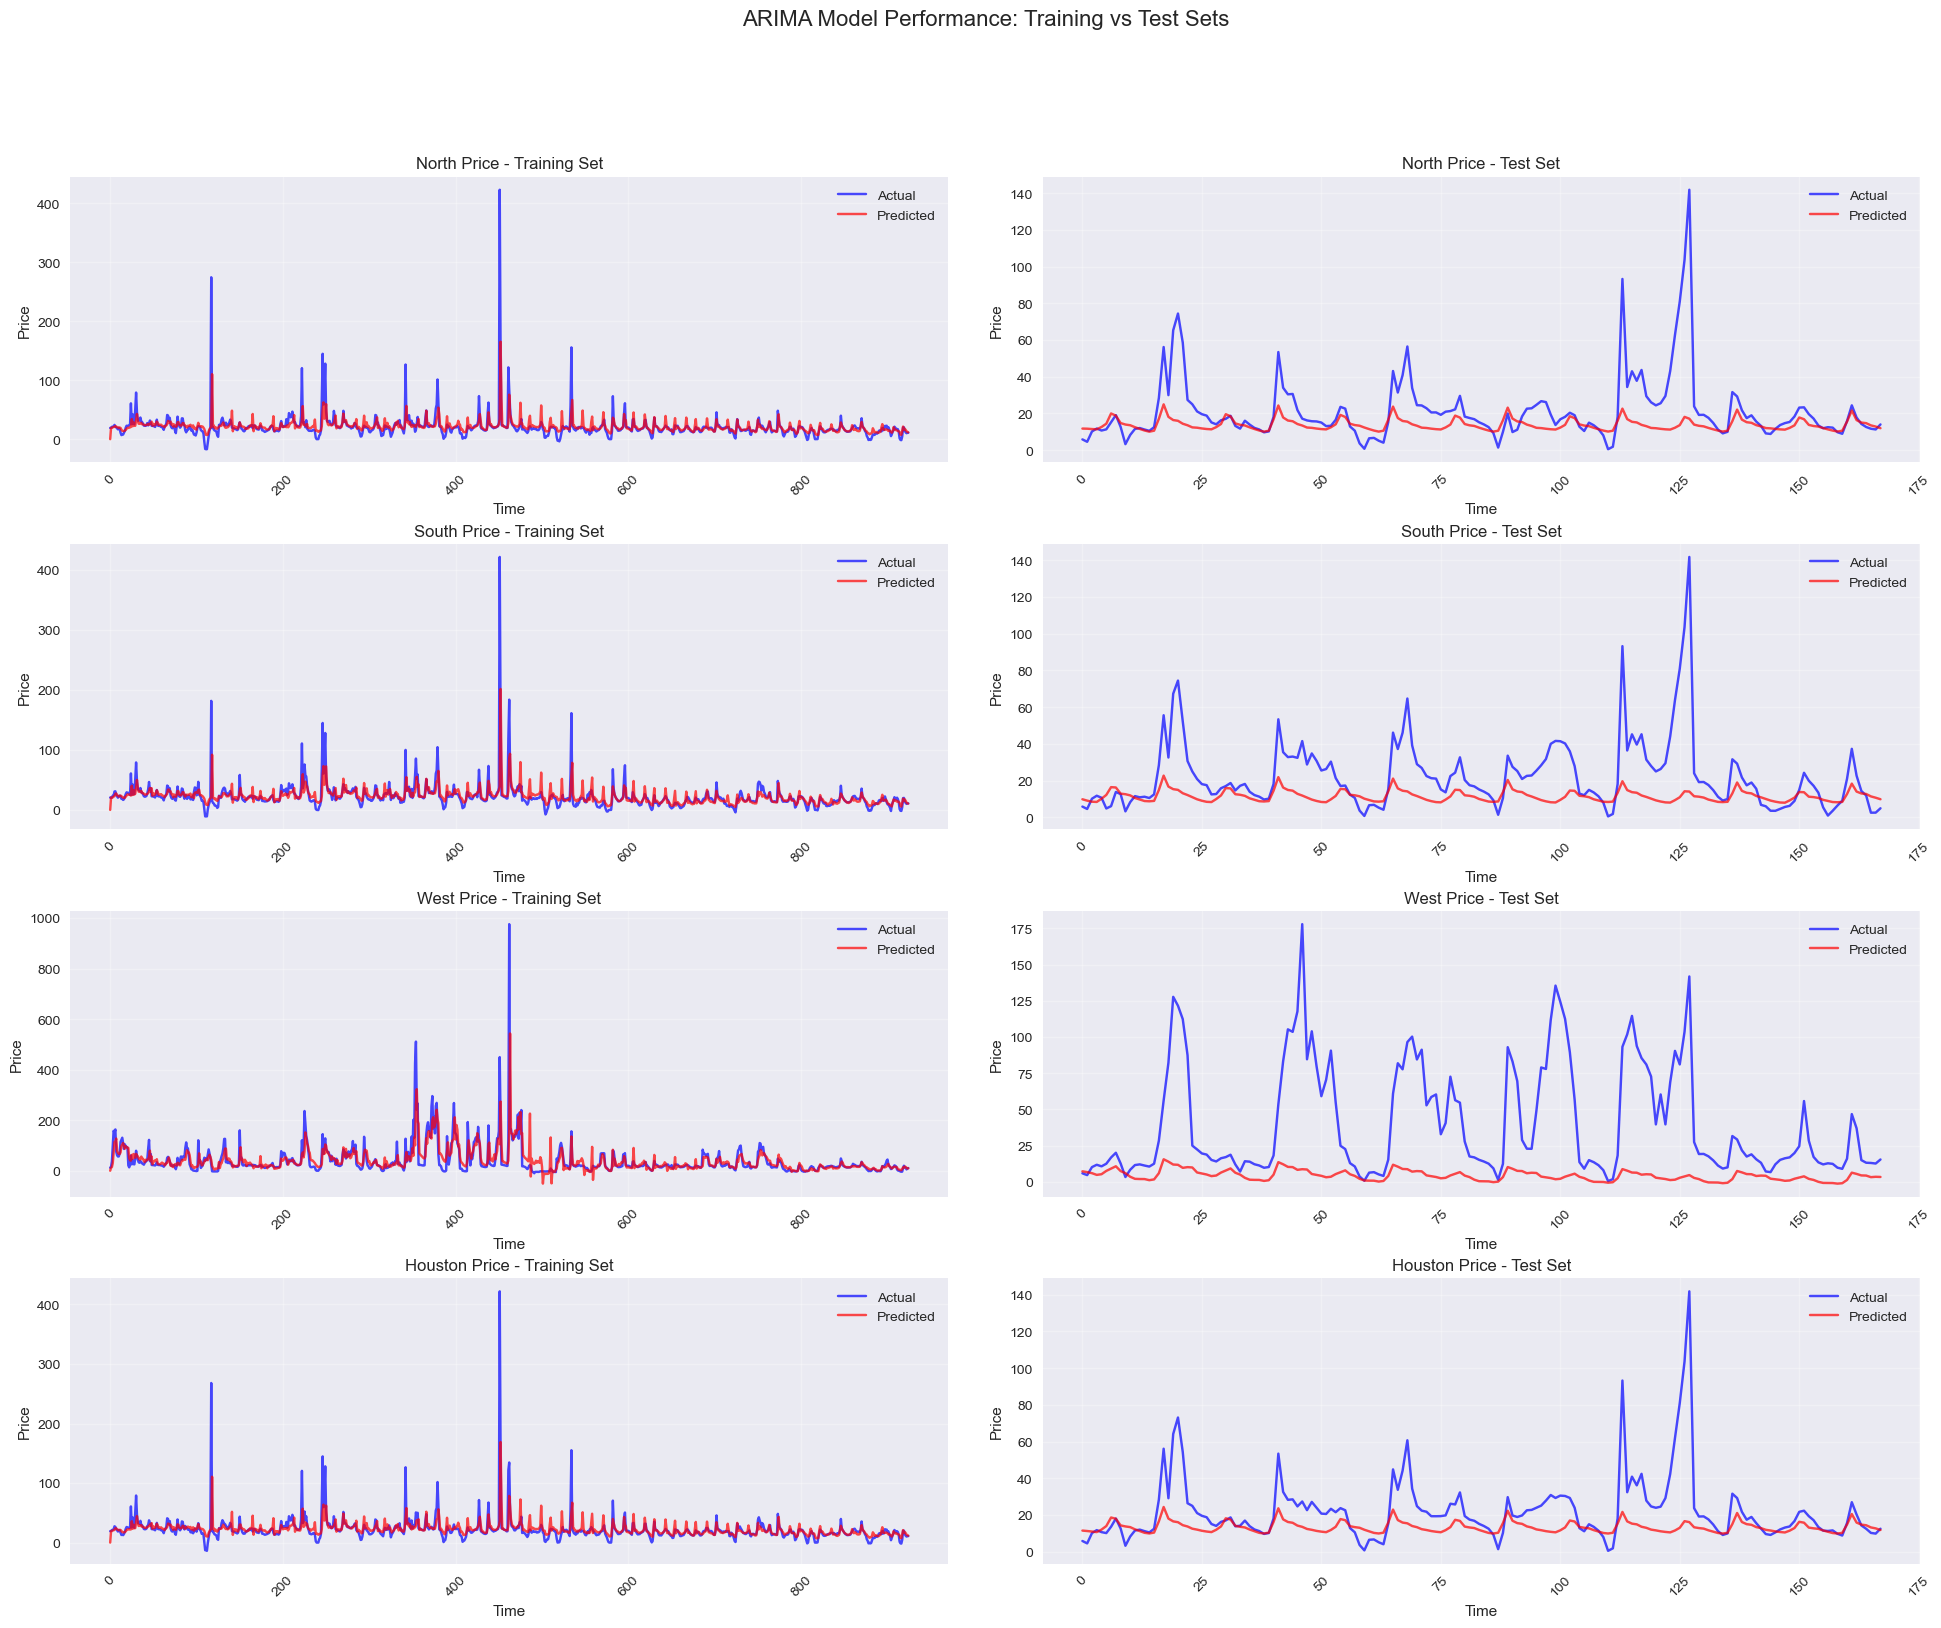

c:\Users\achra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\achra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\achra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\achra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

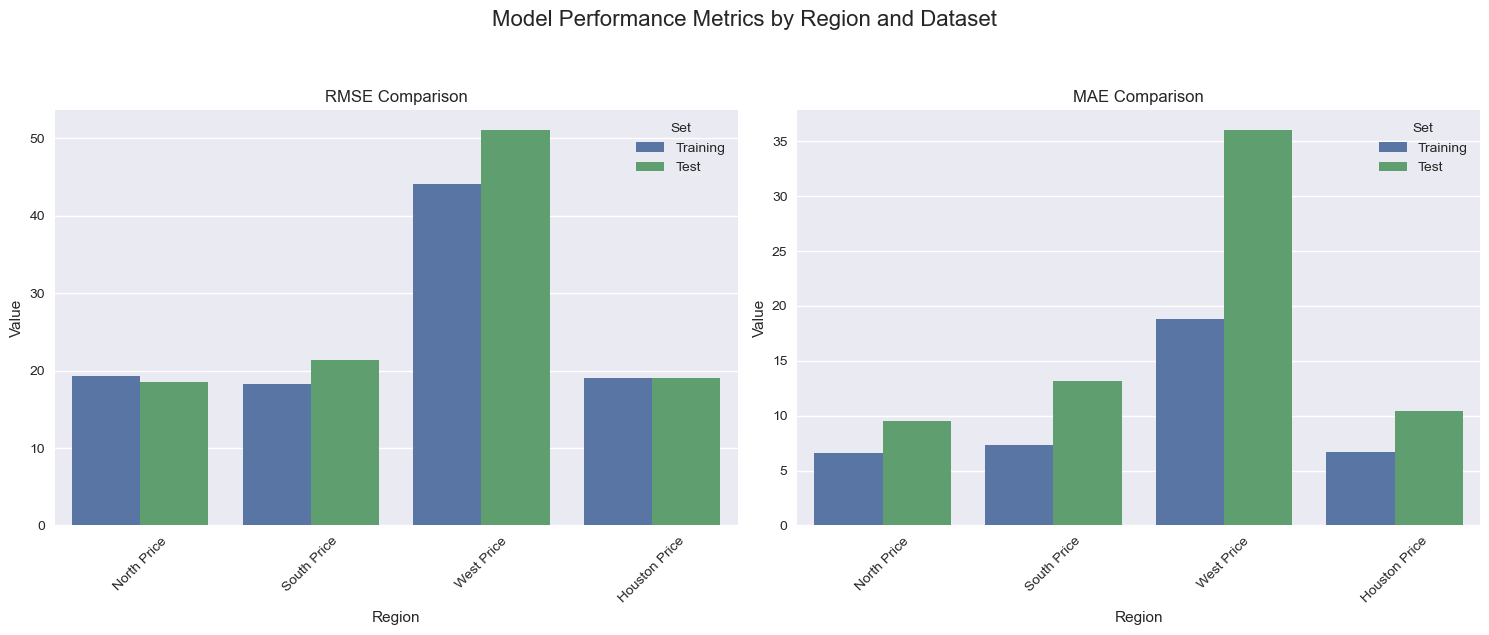


Summary Statistics:

North Price:
Training Set:
Mean Actual Price: 20.82
RMSE: 19.24 (92.41%)
MAE: 6.62 (31.80%)

Test Set:
Mean Actual Price: 21.34
RMSE: 18.54 (86.90%)
MAE: 9.50 (44.54%)

South Price:
Training Set:
Mean Actual Price: 22.09
RMSE: 18.27 (82.70%)
MAE: 7.29 (32.98%)

Test Set:
Mean Actual Price: 22.70
RMSE: 21.35 (94.08%)
MAE: 13.14 (57.88%)

West Price:
Training Set:
Mean Actual Price: 39.90
RMSE: 44.11 (110.56%)
MAE: 18.85 (47.23%)

Test Set:
Mean Actual Price: 40.26
RMSE: 51.04 (126.76%)
MAE: 36.01 (89.45%)

Houston Price:
Training Set:
Mean Actual Price: 21.95
RMSE: 19.07 (86.86%)
MAE: 6.74 (30.69%)

Test Set:
Mean Actual Price: 22.20
RMSE: 19.05 (85.80%)
MAE: 10.44 (47.04%)


In [134]:
def plot_arima_results(train_predictions, test_predictions, train_actuals, test_actuals, target_columns):
    # Set the style
    plt.style.use('seaborn')
    
    # Create a figure with subplots for each price region
    fig, axes = plt.subplots(len(target_columns), 2, figsize=(20, 4*len(target_columns)))
    fig.suptitle('ARIMA Model Performance: Training vs Test Sets', y=1.02, fontsize=16)
    fig.tight_layout(pad=4.0)
    
    # Plot each region
    for idx, column in enumerate(target_columns):
        # Training set plot
        ax_train = axes[idx, 0]
        ax_train.plot(train_actuals.index, train_actuals[column], 
                     label='Actual', color='blue', alpha=0.7)
        ax_train.plot(train_actuals.index, train_predictions[column], 
                     label='Predicted', color='red', alpha=0.7)
        ax_train.set_title(f'{column} - Training Set')
        ax_train.set_xlabel('Time')
        ax_train.set_ylabel('Price')
        ax_train.legend()
        ax_train.grid(True, alpha=0.3)
        plt.setp(ax_train.get_xticklabels(), rotation=45)
        
        # Test set plot
        ax_test = axes[idx, 1]
        ax_test.plot(test_actuals.index, test_actuals[column], 
                    label='Actual', color='blue', alpha=0.7)
        ax_test.plot(test_actuals.index, test_predictions[column], 
                    label='Predicted', color='red', alpha=0.7)
        ax_test.set_title(f'{column} - Test Set')
        ax_test.set_xlabel('Time')
        ax_test.set_ylabel('Price')
        ax_test.legend()
        ax_test.grid(True, alpha=0.3)
        plt.setp(ax_test.get_xticklabels(), rotation=45)
    
    plt.show()

def plot_metrics_comparison(train_metrics, test_metrics, target_columns):
    # Prepare data for plotting
    metric_data = {
        'Region': [],
        'Set': [],
        'Metric': [],
        'Value': []
    }
    
    # Add training metrics
    for region in target_columns:
        for metric, value in train_metrics[region].items():
            metric_data['Region'].append(region)
            metric_data['Set'].append('Training')
            metric_data['Metric'].append(metric)
            metric_data['Value'].append(value)
    
    # Add test metrics
    for region in target_columns:
        for metric, value in test_metrics[region].items():
            metric_data['Region'].append(region)
            metric_data['Set'].append('Test')
            metric_data['Metric'].append(metric)
            metric_data['Value'].append(value)
    
    metric_df = pd.DataFrame(metric_data)
    
    # Create separate plots for each metric
    metrics = metric_df['Metric'].unique()
    fig, axes = plt.subplots(1, len(metrics), figsize=(15, 6))
    fig.suptitle('Model Performance Metrics by Region and Dataset', y=1.05, fontsize=16)
    
    for idx, metric in enumerate(metrics):
        metric_subset = metric_df[metric_df['Metric'] == metric]
        sns.barplot(data=metric_subset, x='Region', y='Value', hue='Set', ax=axes[idx])
        axes[idx].set_title(f'{metric} Comparison')
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

# Print summary statistics
def print_summary_statistics(train_actuals, test_actuals, train_metrics, test_metrics, target_columns):
    print("\nSummary Statistics:")
    for region in target_columns:
        print(f"\n{region}:")
        print("Training Set:")
        train_mean = train_actuals[region].mean()
        print(f"Mean Actual Price: {train_mean:.2f}")
        print(f"RMSE: {train_metrics[region]['RMSE']:.2f} ({(train_metrics[region]['RMSE']/train_mean)*100:.2f}%)")
        print(f"MAE: {train_metrics[region]['MAE']:.2f} ({(train_metrics[region]['MAE']/train_mean)*100:.2f}%)")
        
        print("\nTest Set:")
        test_mean = test_actuals[region].mean()
        print(f"Mean Actual Price: {test_mean:.2f}")
        print(f"RMSE: {test_metrics[region]['RMSE']:.2f} ({(test_metrics[region]['RMSE']/test_mean)*100:.2f}%)")
        print(f"MAE: {test_metrics[region]['MAE']:.2f} ({(test_metrics[region]['MAE']/test_mean)*100:.2f}%)")

# Call all visualization functions
plot_arima_results(train_predictions, test_predictions, train_actuals, test_actuals, target_columns)
plot_metrics_comparison(train_metrics, test_metrics, target_columns)
print_summary_statistics(train_actuals, test_actuals, train_metrics, test_metrics, target_columns)

df_train_scaled.shape

c:\Users\achra\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - loss: 0.0130 - mae: 0.0909 - val_loss: 0.0023 - val_mae: 0.0543 - learning_rate: 0.0010
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0095 - mae: 0.0672 - val_loss: 0.0022 - val_mae: 0.0514 - learning_rate: 0.0010
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0080 - mae: 0.0608 - val_loss: 0.0025 - val_mae: 0.0572 - learning_rate: 0.0010
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0078 - mae: 0.0598 - val_loss: 0.0015 - val_mae: 0.0391 - learning_rate: 0.0010
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0067 - mae: 0.0529 - val_loss: 0.0016 - val_mae: 0.0417 - learning_rate: 0.0010
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0063 - mae: 0.0514 - val_loss: 0.0016 - val_mae: 0.0432 - learning_rate: 0.0010
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0059 - mae: 0.0512 - val_loss: 0.0014 - val_mae: 0.0373 - learning_rate: 0.0010
Epoch

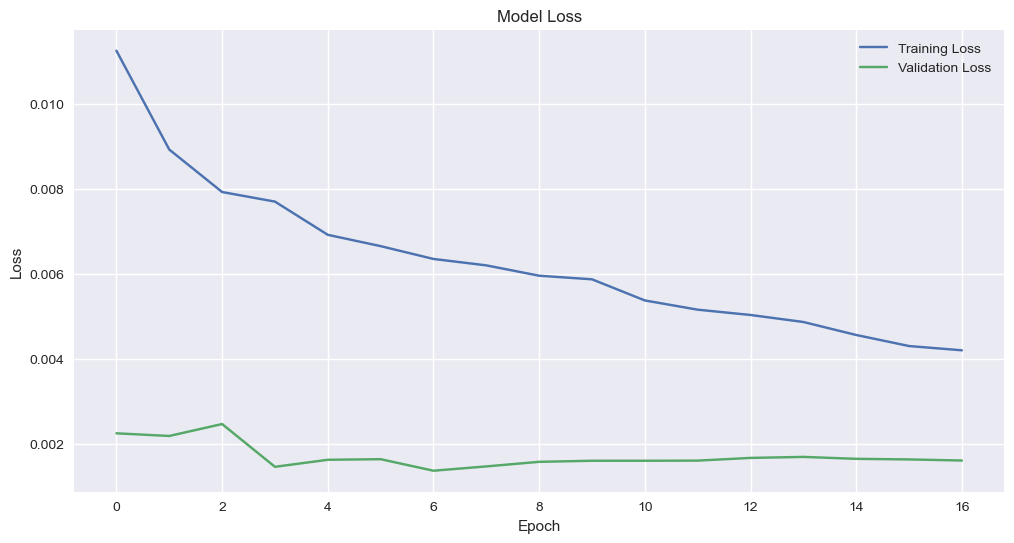

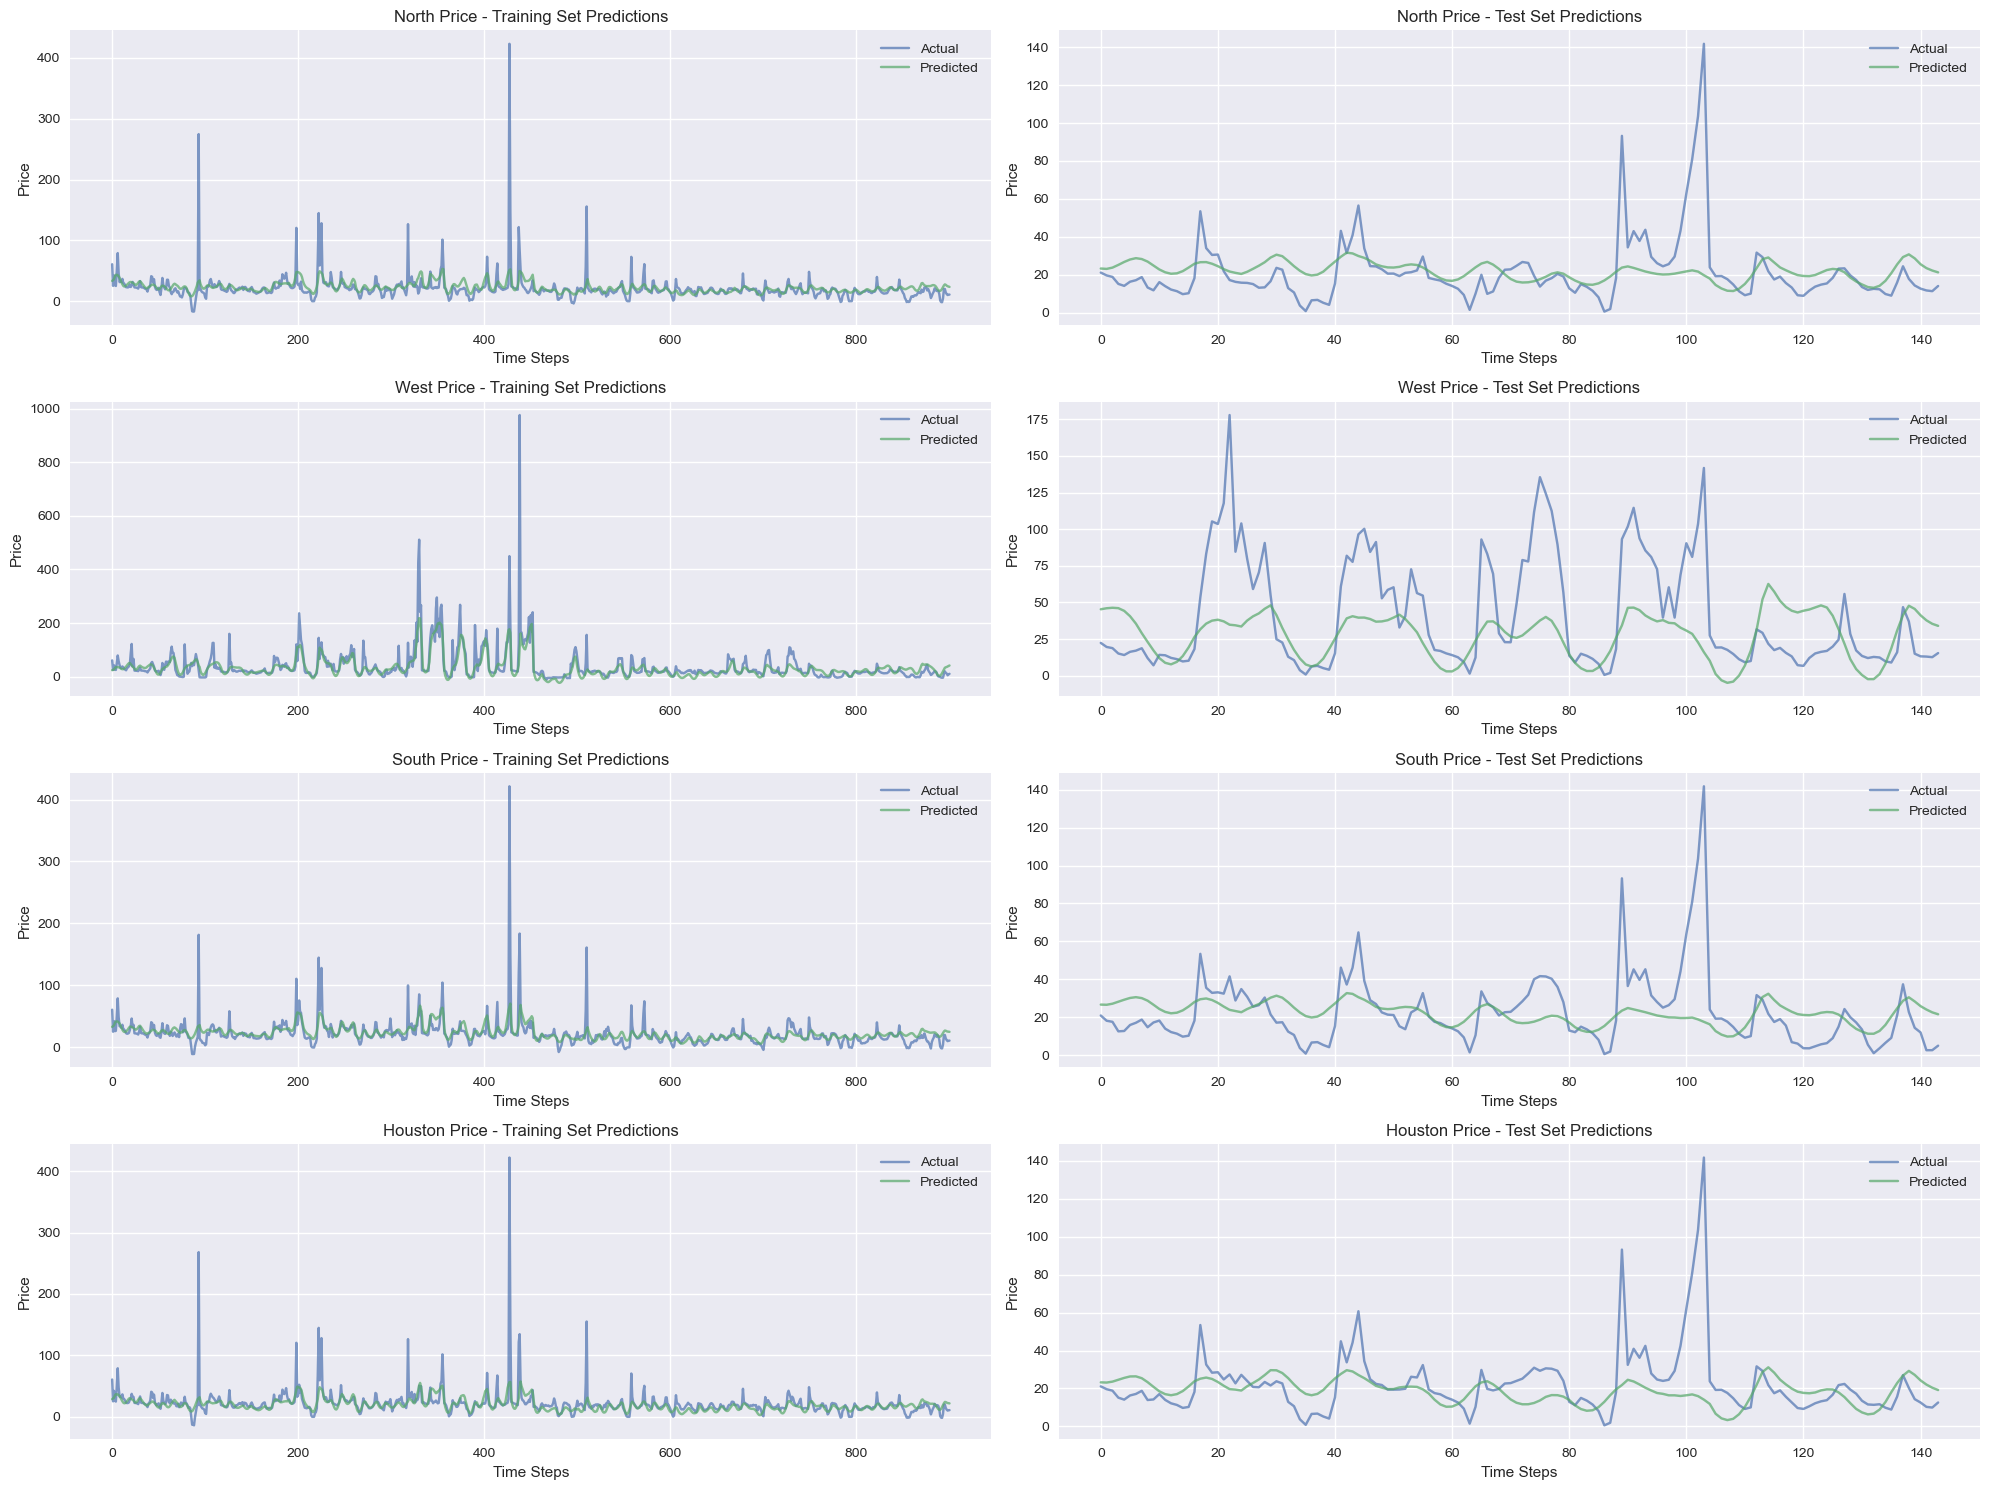

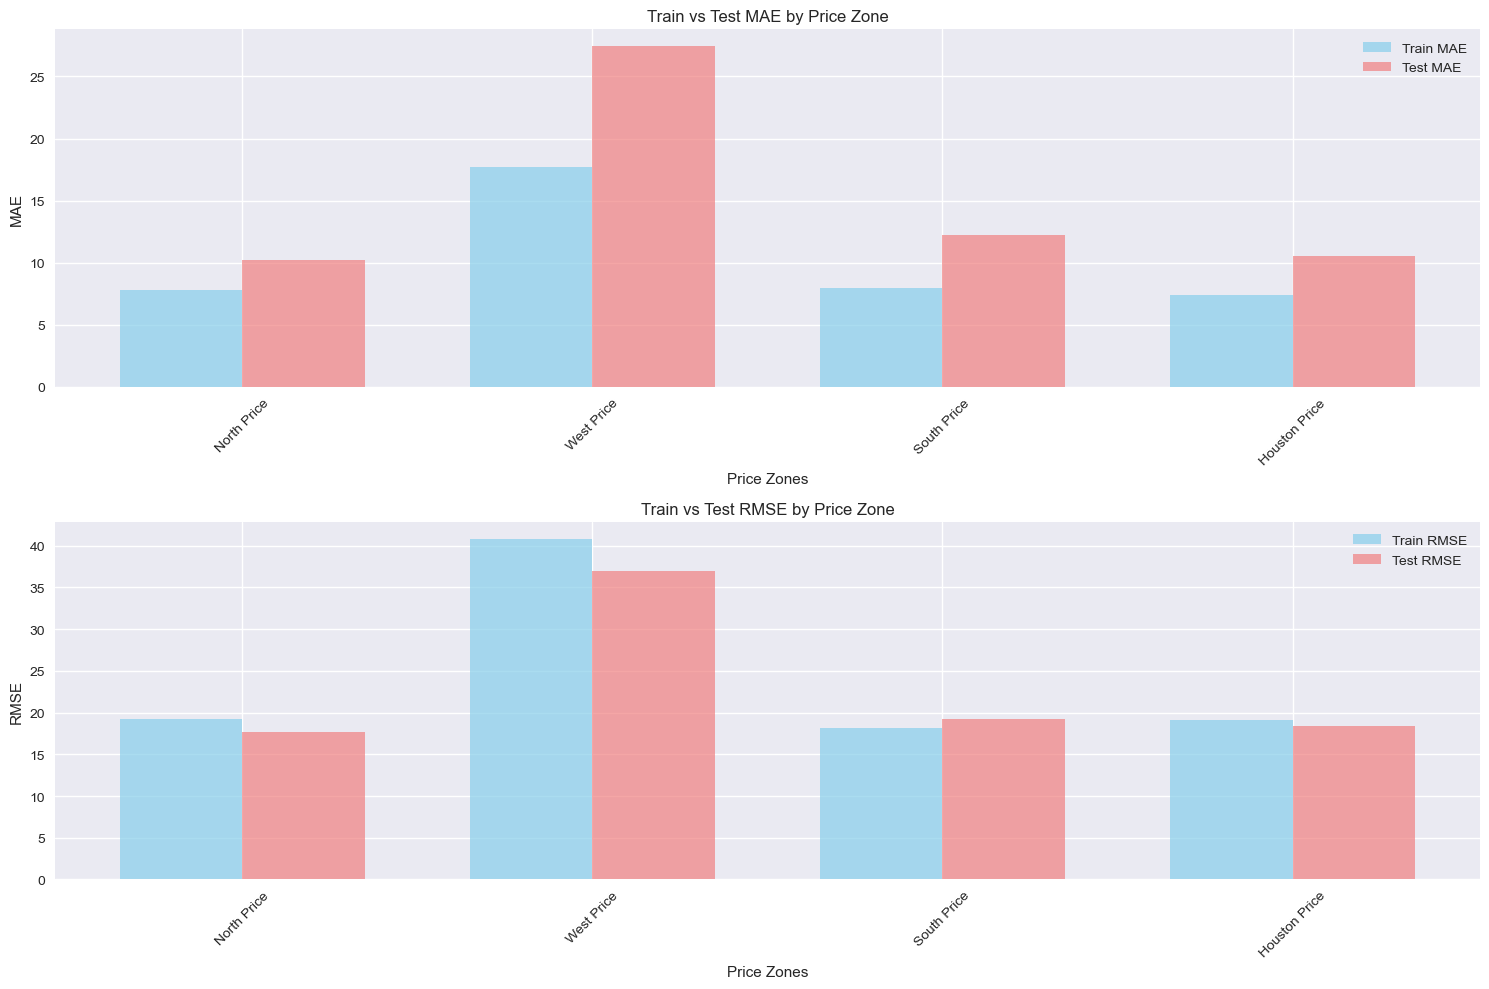


DETAILED PERFORMANCE METRICS

Training Set Metrics:
--------------------

North Price:
MAE: 7.8171
RMSE: 19.2651

West Price:
MAE: 17.7007
RMSE: 40.8186

South Price:
MAE: 7.9472
RMSE: 18.1103

Houston Price:
MAE: 7.4047
RMSE: 19.0819

Test Set Metrics:
--------------------

North Price:
MAE: 10.2442
RMSE: 17.6237

West Price:
MAE: 27.4190
RMSE: 36.9232

South Price:
MAE: 12.2548
RMSE: 19.1930

Houston Price:
MAE: 10.5256
RMSE: 18.4211

Comparative Analysis:
--------------------

North Price:
Train-Test MAE Difference: 2.4271
Train-Test RMSE Difference: 1.6414
MAE Ratio (Test/Train): 1.31
RMSE Ratio (Test/Train): 0.91

West Price:
Train-Test MAE Difference: 9.7183
Train-Test RMSE Difference: 3.8954
MAE Ratio (Test/Train): 1.55
RMSE Ratio (Test/Train): 0.90

South Price:
Train-Test MAE Difference: 4.3076
Train-Test RMSE Difference: 1.0828
MAE Ratio (Test/Train): 1.54
RMSE Ratio (Test/Train): 1.06

Houston Price:
Train-Test MAE Difference: 3.1210
Train-Test RMSE Difference: 0.6607
MAE R

In [135]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Define constants for unscaled features
UNSCALED_FEATURES = ['month_sin', 'month_cos', 'day_of_week_sin', 
                     'day_of_week_cos', 'Is_Holiday', 'hour_sin', 'hour_cos']

def create_sequences(data, n_steps):
    """Create sequences for LSTM training"""
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), :])
        y.append(data[i + n_steps, :4])  # First 4 columns are the prices
    return np.array(X), np.array(y)

def build_model(n_steps, n_features, n_outputs):
    """Build enhanced LSTM model"""
    model = Sequential([
        Bidirectional(
            LSTM(256, activation='relu', return_sequences=True),
            input_shape=(n_steps, n_features)
        ),
        Dropout(0.1),
        
        Bidirectional(LSTM(128, activation='relu', return_sequences=True)),
        Dropout(0.01),
        
        Bidirectional(LSTM(64, activation='relu')),
        Dropout(0.01),
        
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(n_outputs)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
        loss=tf.keras.losses.Huber(delta=1.0),
        metrics=['mae']
    )
    return model

def inverse_transform_with_unscaled(scaled_data, scaler, original_data, price_columns, n_steps):
    """Inverse transform the scaled data while preserving unscaled features"""
    unscaled_indices = [list(original_data.columns).index(col) for col in UNSCALED_FEATURES]
    scaled_indices = [i for i in range(original_data.shape[1]) if i not in unscaled_indices]
    
    full_data = np.zeros((scaled_data.shape[0], len(scaled_indices)))
    
    start_idx = n_steps
    end_idx = start_idx + scaled_data.shape[0]
    
    scaled_data_subset = scaled_data[:, scaled_indices]
    full_data = scaled_data_subset
    
    inverse_scaled = scaler.inverse_transform(full_data)
    
    final_data = np.zeros((scaled_data.shape[0], original_data.shape[1]))
    final_data[:, scaled_indices] = inverse_scaled
    
    for i, idx in enumerate(unscaled_indices):
        final_data[:, idx] = original_data.iloc[start_idx:end_idx, idx].values
    
    price_indices = [list(original_data.columns).index(col) for col in price_columns]
    return final_data[:, price_indices]

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Prepare data
n_steps = 24
n_features = df_train_scaled.shape[1]
n_outputs = 4
price_columns = ['North Price', 'West Price', 'South Price', 'Houston Price']

# Create sequences
X_train, y_train = create_sequences(df_train_scaled.values, n_steps)
X_test, y_test = create_sequences(df_test_scaled.values, n_steps)

# Build and train model
model = build_model(n_steps, n_features, n_outputs)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
]

# Train model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=12,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Prepare data for inverse transform
train_last_rows = X_train[:, -1, :]
test_last_rows = X_test[:, -1, :]

train_inverse_data = train_last_rows.copy()
test_inverse_data = test_last_rows.copy()
train_inverse_data[:, :4] = train_pred
test_inverse_data[:, :4] = test_pred

train_actual_data = train_last_rows.copy()
test_actual_data = test_last_rows.copy()
train_actual_data[:, :4] = y_train
test_actual_data[:, :4] = y_test

# Inverse transform predictions and actuals
train_pred_inv = inverse_transform_with_unscaled(train_inverse_data, scaler, 
                                               df_train_scaled, price_columns, n_steps)
test_pred_inv = inverse_transform_with_unscaled(test_inverse_data, scaler, 
                                              df_test_scaled, price_columns, n_steps)
train_actual_inv = inverse_transform_with_unscaled(train_actual_data, scaler, 
                                                 df_train_scaled, price_columns, n_steps)
test_actual_inv = inverse_transform_with_unscaled(test_actual_data, scaler, 
                                                df_test_scaled, price_columns, n_steps)

# Calculate metrics
train_mae = np.mean(np.abs(train_actual_inv - train_pred_inv), axis=0)
test_mae = np.mean(np.abs(test_actual_inv - test_pred_inv), axis=0)
train_rmse = np.sqrt(np.mean(np.square(train_actual_inv - train_pred_inv), axis=0))
test_rmse = np.sqrt(np.mean(np.square(test_actual_inv - test_pred_inv), axis=0))

# 1. Plot Training History
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2. Plot Predictions
plt.figure(figsize=(20, 15))
for i, name in enumerate(price_columns):
    # Training set
    plt.subplot(4, 2, 2*i+1)
    plt.plot(train_actual_inv[:, i], label='Actual', alpha=0.7)
    plt.plot(train_pred_inv[:, i], label='Predicted', alpha=0.7)
    plt.title(f'{name} - Training Set Predictions')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    
    # Test set
    plt.subplot(4, 2, 2*i+2)
    plt.plot(test_actual_inv[:, i], label='Actual', alpha=0.7)
    plt.plot(test_pred_inv[:, i], label='Predicted', alpha=0.7)
    plt.title(f'{name} - Test Set Predictions')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
plt.tight_layout()
plt.show()

# 3. Plot Metrics Comparison
plt.figure(figsize=(15, 10))
x = np.arange(len(price_columns))
width = 0.35

# MAE Comparison
plt.subplot(2, 1, 1)
plt.bar(x - width/2, train_mae, width, label='Train MAE', color='skyblue', alpha=0.7)
plt.bar(x + width/2, test_mae, width, label='Test MAE', color='lightcoral', alpha=0.7)
plt.xlabel('Price Zones')
plt.ylabel('MAE')
plt.title('Train vs Test MAE by Price Zone')
plt.xticks(x, price_columns, rotation=45)
plt.legend()

# RMSE Comparison
plt.subplot(2, 1, 2)
plt.bar(x - width/2, train_rmse, width, label='Train RMSE', color='skyblue', alpha=0.7)
plt.bar(x + width/2, test_rmse, width, label='Test RMSE', color='lightcoral', alpha=0.7)
plt.xlabel('Price Zones')
plt.ylabel('RMSE')
plt.title('Train vs Test RMSE by Price Zone')
plt.xticks(x, price_columns, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Print metrics
print("\n" + "="*50)
print("DETAILED PERFORMANCE METRICS")
print("="*50)

print("\nTraining Set Metrics:")
print("-"*20)
for name, mae, rmse in zip(price_columns, train_mae, train_rmse):
    print(f"\n{name}:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

print("\nTest Set Metrics:")
print("-"*20)
for name, mae, rmse in zip(price_columns, test_mae, test_rmse):
    print(f"\n{name}:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

print("\nComparative Analysis:")
print("-"*20)
for i, name in enumerate(price_columns):
    print(f"\n{name}:")
    print(f"Train-Test MAE Difference: {abs(train_mae[i] - test_mae[i]):.4f}")
    print(f"Train-Test RMSE Difference: {abs(train_rmse[i] - test_rmse[i]):.4f}")
    print(f"MAE Ratio (Test/Train): {(test_mae[i]/train_mae[i]):.2f}")
    print(f"RMSE Ratio (Test/Train): {(test_rmse[i]/train_rmse[i]):.2f}")

c:\Users\achra\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.0132 - mae: 0.0913 - val_loss: 0.0026 - val_mae: 0.0584 - learning_rate: 0.0010
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0097 - mae: 0.0694 - val_loss: 0.0020 - val_mae: 0.0506 - learning_rate: 0.0010
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0080 - mae: 0.0610 - val_loss: 0.0021 - val_mae: 0.0525 - learning_rate: 0.0010
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0076 - mae: 0.0587 - val_loss: 0.0013 - val_mae: 0.0358 - learning_rate: 0.0010
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0065 - mae: 0.0528 - val_loss: 0.0018 - val_mae: 0.0446 - learning_rate: 0.0010
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0059 - mae: 0.0509 - val_loss: 0.0015 - val_mae: 0.0389 - learning_rate: 0.0010
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0056 - mae: 0.0501 - val_loss: 0.0020 - val_mae: 0.0475 - learning_rate: 0.0010
Epoch

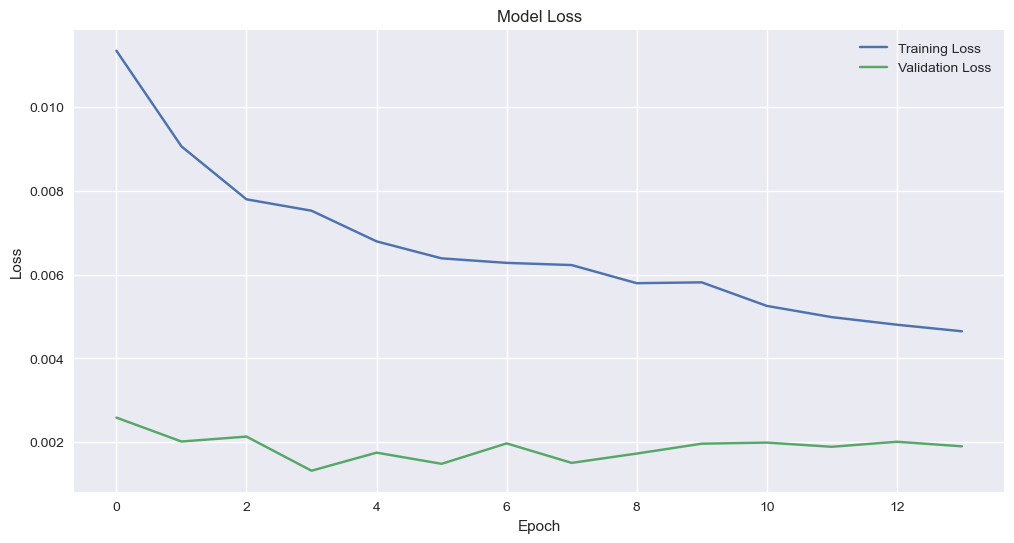

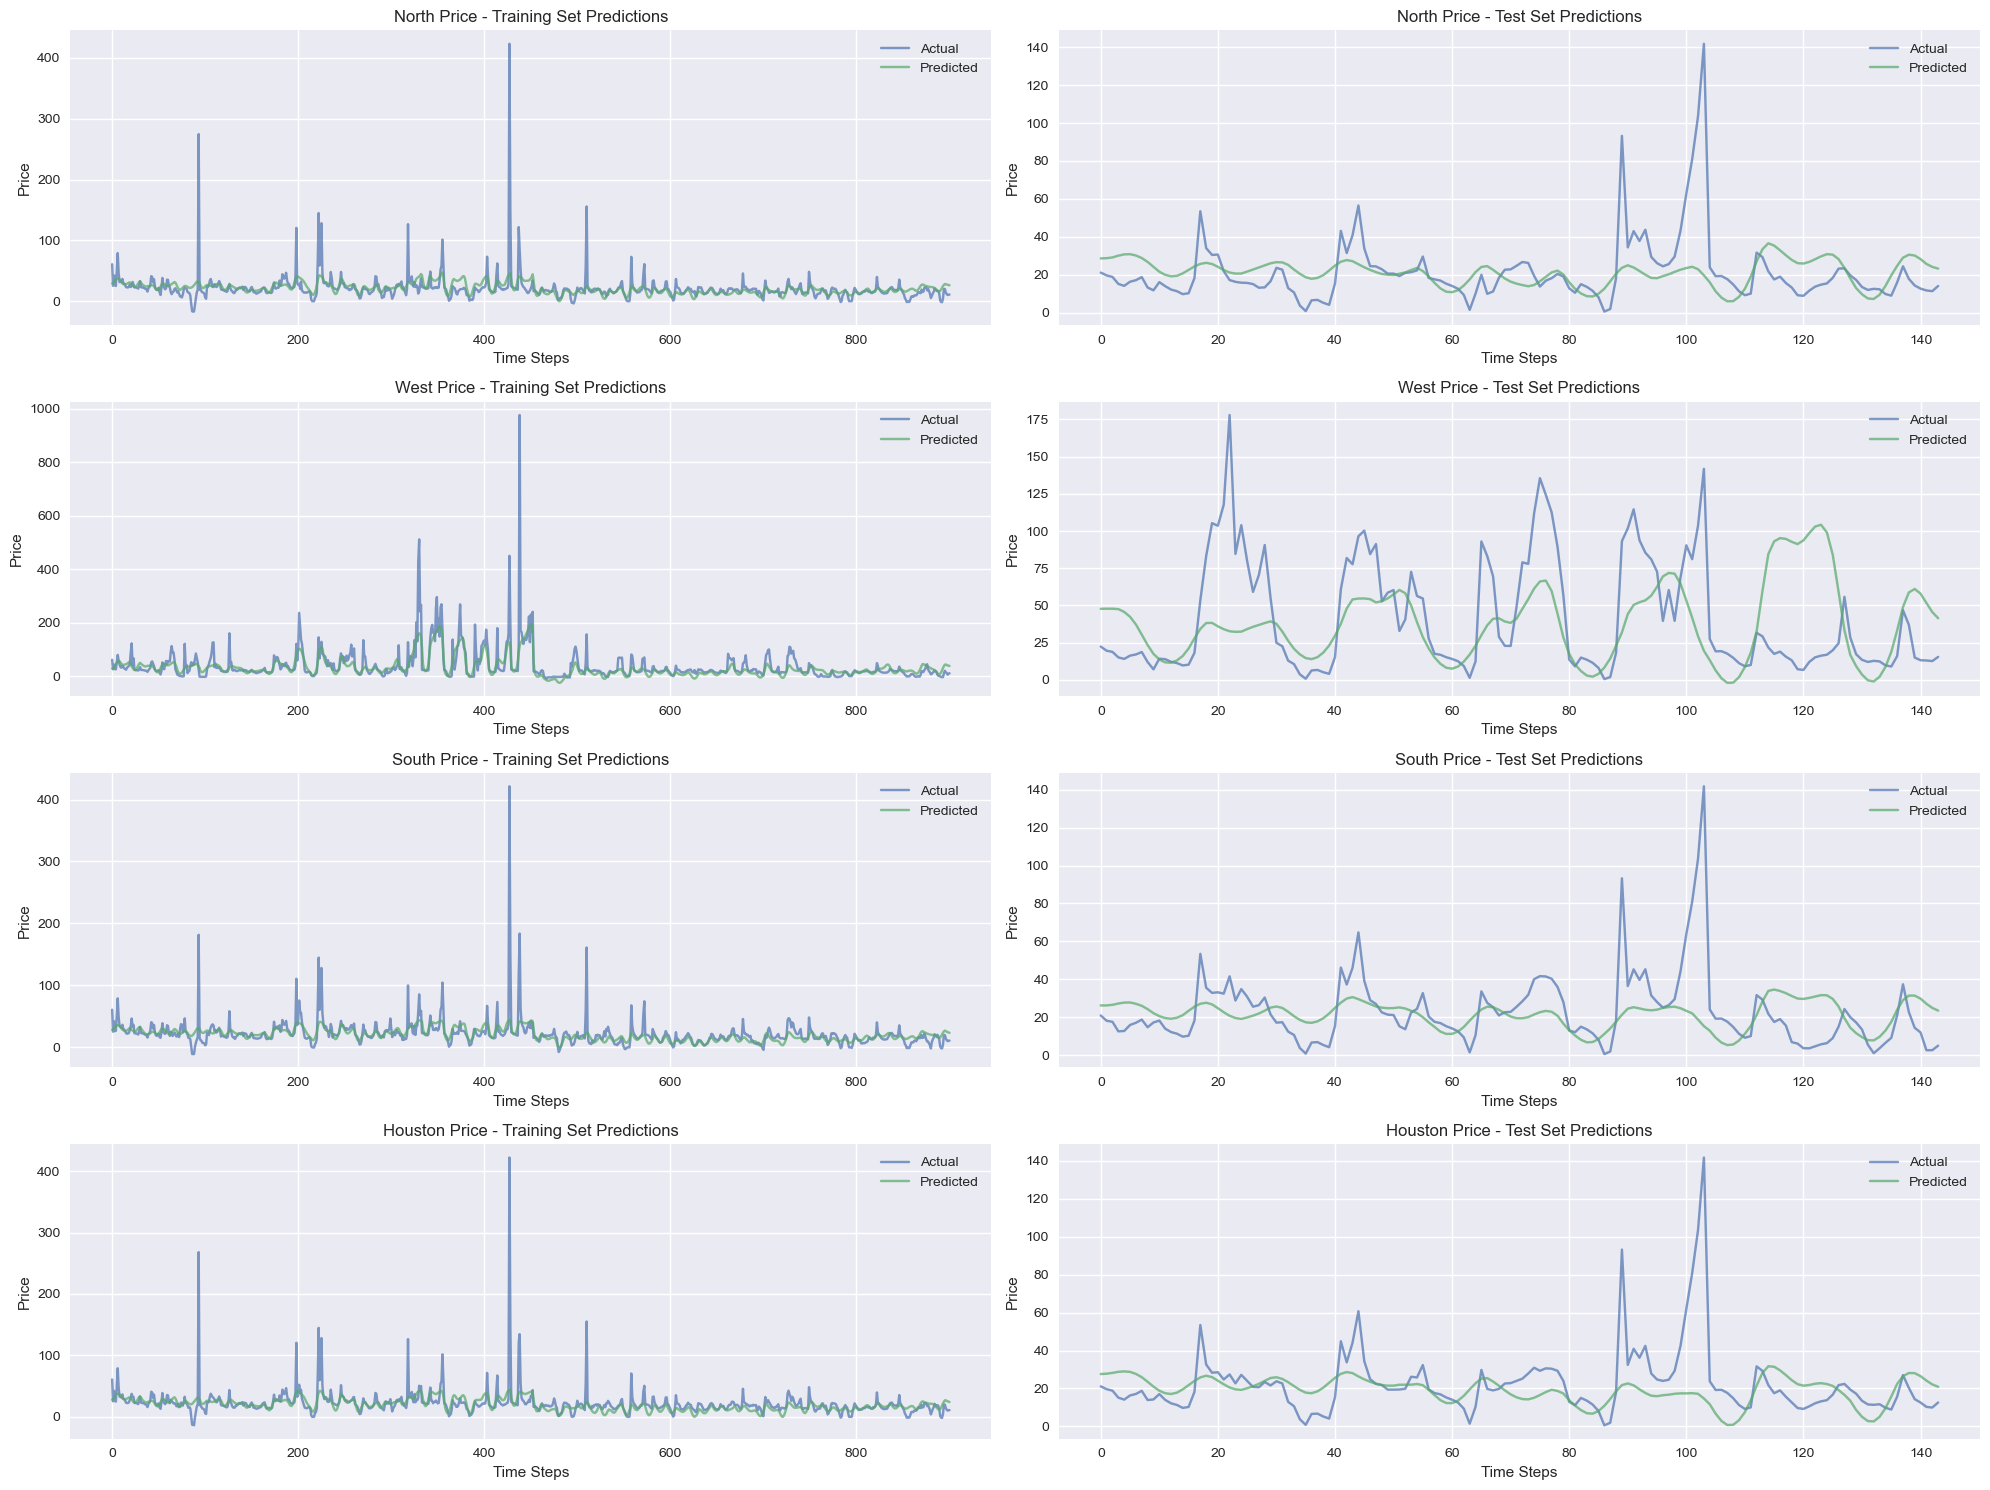

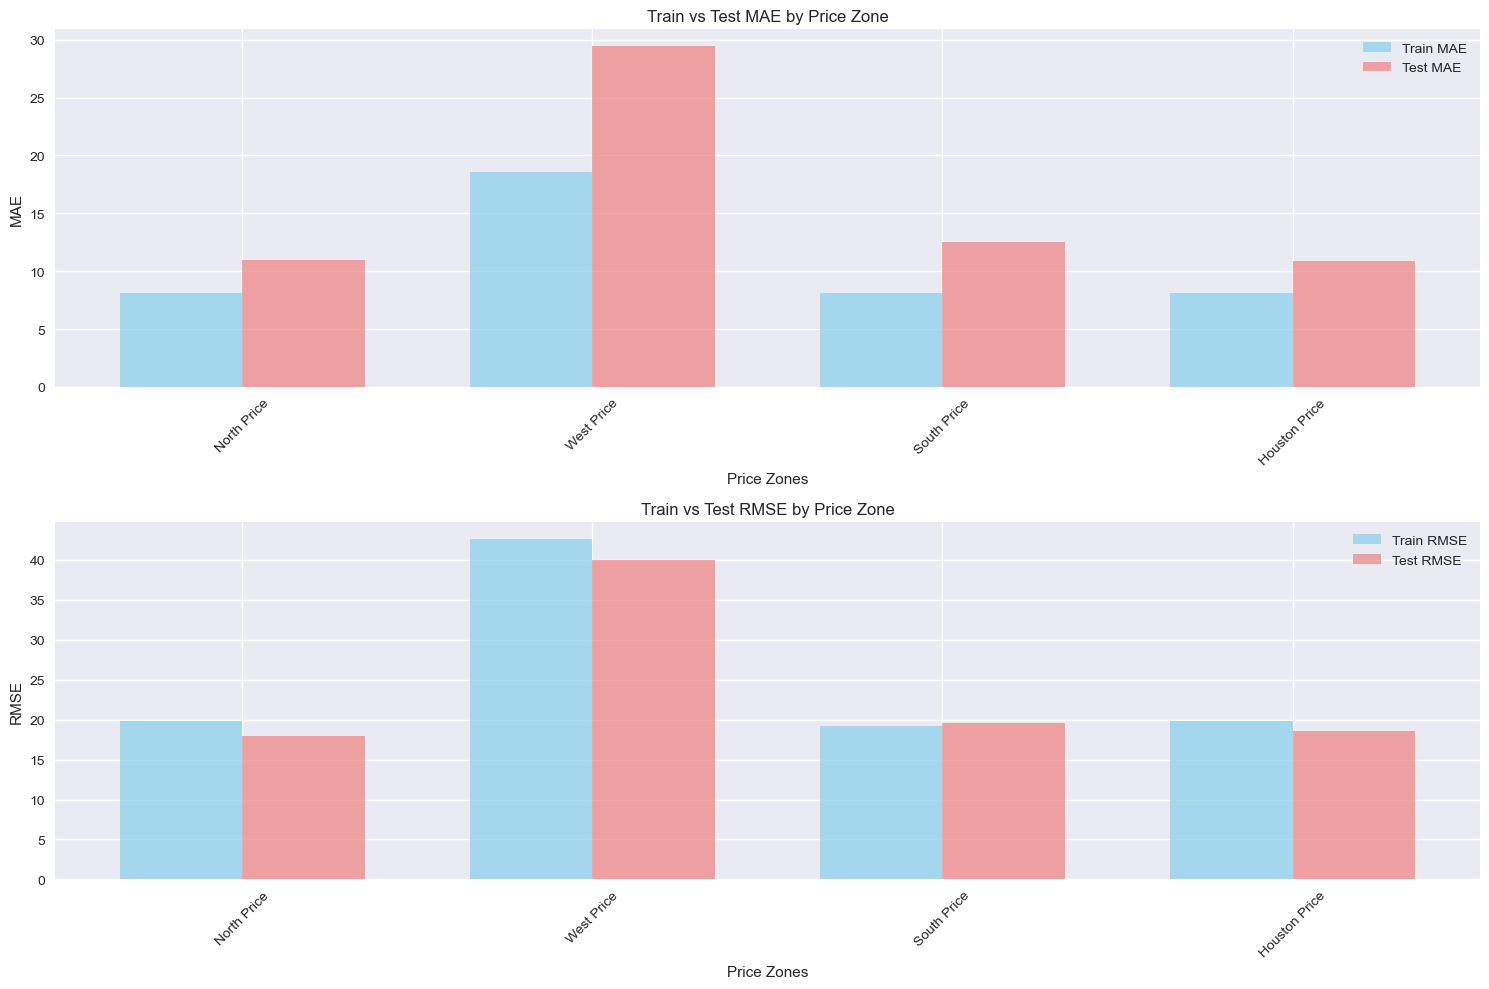


DETAILED PERFORMANCE METRICS

Training Set Metrics:
--------------------

North Price:
MAE: 8.1161
RMSE: 19.8051

West Price:
MAE: 18.5874
RMSE: 42.5976

South Price:
MAE: 8.1380
RMSE: 19.2110

Houston Price:
MAE: 8.1028
RMSE: 19.7641

Test Set Metrics:
--------------------

North Price:
MAE: 10.9971
RMSE: 17.9770

West Price:
MAE: 29.4169
RMSE: 39.9269

South Price:
MAE: 12.4909
RMSE: 19.5543

Houston Price:
MAE: 10.8936
RMSE: 18.5686

Comparative Analysis:
--------------------

North Price:
Train-Test MAE Difference: 2.8810
Train-Test RMSE Difference: 1.8281
MAE Ratio (Test/Train): 1.35
RMSE Ratio (Test/Train): 0.91

West Price:
Train-Test MAE Difference: 10.8295
Train-Test RMSE Difference: 2.6708
MAE Ratio (Test/Train): 1.58
RMSE Ratio (Test/Train): 0.94

South Price:
Train-Test MAE Difference: 4.3530
Train-Test RMSE Difference: 0.3433
MAE Ratio (Test/Train): 1.53
RMSE Ratio (Test/Train): 1.02

Houston Price:
Train-Test MAE Difference: 2.7907
Train-Test RMSE Difference: 1.1955
MAE 

In [136]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Define constants for unscaled features
UNSCALED_FEATURES = ['month_sin', 'month_cos', 'day_of_week_sin', 
                     'day_of_week_cos', 'Is_Holiday', 'hour_sin', 'hour_cos']

def create_sequences(data, n_steps):
    """Create sequences for LSTM training"""
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), :])
        y.append(data[i + n_steps, :4])  # First 4 columns are the prices
    return np.array(X), np.array(y)

def build_model(n_steps, n_features, n_outputs):
    """Build enhanced LSTM model"""
    model = Sequential([
        Bidirectional(
            LSTM(256, activation='relu', return_sequences=True),
            input_shape=(n_steps, n_features)
        ),
        Dropout(0.1),
        
        Bidirectional(LSTM(128, activation='relu', return_sequences=True)),
        Dropout(0.01),
        
        Bidirectional(LSTM(64, activation='relu')),
        Dropout(0.01),
        
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(n_outputs)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
        loss=tf.keras.losses.Huber(delta=1.0),
        metrics=['mae']
    )
    return model

def inverse_transform_with_unscaled(scaled_data, scaler, original_data, price_columns, n_steps):
    """Inverse transform the scaled data while preserving unscaled features"""
    unscaled_indices = [list(original_data.columns).index(col) for col in UNSCALED_FEATURES]
    scaled_indices = [i for i in range(original_data.shape[1]) if i not in unscaled_indices]
    
    full_data = np.zeros((scaled_data.shape[0], len(scaled_indices)))
    
    start_idx = n_steps
    end_idx = start_idx + scaled_data.shape[0]
    
    scaled_data_subset = scaled_data[:, scaled_indices]
    full_data = scaled_data_subset
    
    inverse_scaled = scaler.inverse_transform(full_data)
    
    final_data = np.zeros((scaled_data.shape[0], original_data.shape[1]))
    final_data[:, scaled_indices] = inverse_scaled
    
    for i, idx in enumerate(unscaled_indices):
        final_data[:, idx] = original_data.iloc[start_idx:end_idx, idx].values
    
    price_indices = [list(original_data.columns).index(col) for col in price_columns]
    return final_data[:, price_indices]

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Prepare data
n_steps = 24
n_features = df_train_scaled.shape[1]
n_outputs = 4
price_columns = ['North Price', 'West Price', 'South Price', 'Houston Price']

# Create sequences
X_train, y_train = create_sequences(df_train_scaled.values, n_steps)
X_test, y_test = create_sequences(df_test_scaled.values, n_steps)

# Build and train model
model = build_model(n_steps, n_features, n_outputs)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
]

# Train model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=12,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Prepare data for inverse transform
train_last_rows = X_train[:, -1, :]
test_last_rows = X_test[:, -1, :]

train_inverse_data = train_last_rows.copy()
test_inverse_data = test_last_rows.copy()
train_inverse_data[:, :4] = train_pred
test_inverse_data[:, :4] = test_pred

train_actual_data = train_last_rows.copy()
test_actual_data = test_last_rows.copy()
train_actual_data[:, :4] = y_train
test_actual_data[:, :4] = y_test

# Inverse transform predictions and actuals
train_pred_inv = inverse_transform_with_unscaled(train_inverse_data, scaler, 
                                               df_train_scaled, price_columns, n_steps)
test_pred_inv = inverse_transform_with_unscaled(test_inverse_data, scaler, 
                                              df_test_scaled, price_columns, n_steps)
train_actual_inv = inverse_transform_with_unscaled(train_actual_data, scaler, 
                                                 df_train_scaled, price_columns, n_steps)
test_actual_inv = inverse_transform_with_unscaled(test_actual_data, scaler, 
                                                df_test_scaled, price_columns, n_steps)

# Calculate metrics
train_mae = np.mean(np.abs(train_actual_inv - train_pred_inv), axis=0)
test_mae = np.mean(np.abs(test_actual_inv - test_pred_inv), axis=0)
train_rmse = np.sqrt(np.mean(np.square(train_actual_inv - train_pred_inv), axis=0))
test_rmse = np.sqrt(np.mean(np.square(test_actual_inv - test_pred_inv), axis=0))

# 1. Plot Training History
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2. Plot Predictions
plt.figure(figsize=(20, 15))
for i, name in enumerate(price_columns):
    # Training set
    plt.subplot(4, 2, 2*i+1)
    plt.plot(train_actual_inv[:, i], label='Actual', alpha=0.7)
    plt.plot(train_pred_inv[:, i], label='Predicted', alpha=0.7)
    plt.title(f'{name} - Training Set Predictions')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    
    # Test set
    plt.subplot(4, 2, 2*i+2)
    plt.plot(test_actual_inv[:, i], label='Actual', alpha=0.7)
    plt.plot(test_pred_inv[:, i], label='Predicted', alpha=0.7)
    plt.title(f'{name} - Test Set Predictions')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
plt.tight_layout()
plt.show()

# 3. Plot Metrics Comparison
plt.figure(figsize=(15, 10))
x = np.arange(len(price_columns))
width = 0.35

# MAE Comparison
plt.subplot(2, 1, 1)
plt.bar(x - width/2, train_mae, width, label='Train MAE', color='skyblue', alpha=0.7)
plt.bar(x + width/2, test_mae, width, label='Test MAE', color='lightcoral', alpha=0.7)
plt.xlabel('Price Zones')
plt.ylabel('MAE')
plt.title('Train vs Test MAE by Price Zone')
plt.xticks(x, price_columns, rotation=45)
plt.legend()

# RMSE Comparison
plt.subplot(2, 1, 2)
plt.bar(x - width/2, train_rmse, width, label='Train RMSE', color='skyblue', alpha=0.7)
plt.bar(x + width/2, test_rmse, width, label='Test RMSE', color='lightcoral', alpha=0.7)
plt.xlabel('Price Zones')
plt.ylabel('RMSE')
plt.title('Train vs Test RMSE by Price Zone')
plt.xticks(x, price_columns, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Print metrics
print("\n" + "="*50)
print("DETAILED PERFORMANCE METRICS")
print("="*50)

print("\nTraining Set Metrics:")
print("-"*20)
for name, mae, rmse in zip(price_columns, train_mae, train_rmse):
    print(f"\n{name}:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

print("\nTest Set Metrics:")
print("-"*20)
for name, mae, rmse in zip(price_columns, test_mae, test_rmse):
    print(f"\n{name}:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

print("\nComparative Analysis:")
print("-"*20)
for i, name in enumerate(price_columns):
    print(f"\n{name}:")
    print(f"Train-Test MAE Difference: {abs(train_mae[i] - test_mae[i]):.4f}")
    print(f"Train-Test RMSE Difference: {abs(train_rmse[i] - test_rmse[i]):.4f}")
    print(f"MAE Ratio (Test/Train): {(test_mae[i]/train_mae[i]):.2f}")
    print(f"RMSE Ratio (Test/Train): {(test_rmse[i]/train_rmse[i]):.2f}")

Shapes before alignment:
LSTM predictions shape: (144, 4)
ARIMA predictions shape: (72, 4)
ARIMA actuals shape: (72, 39)


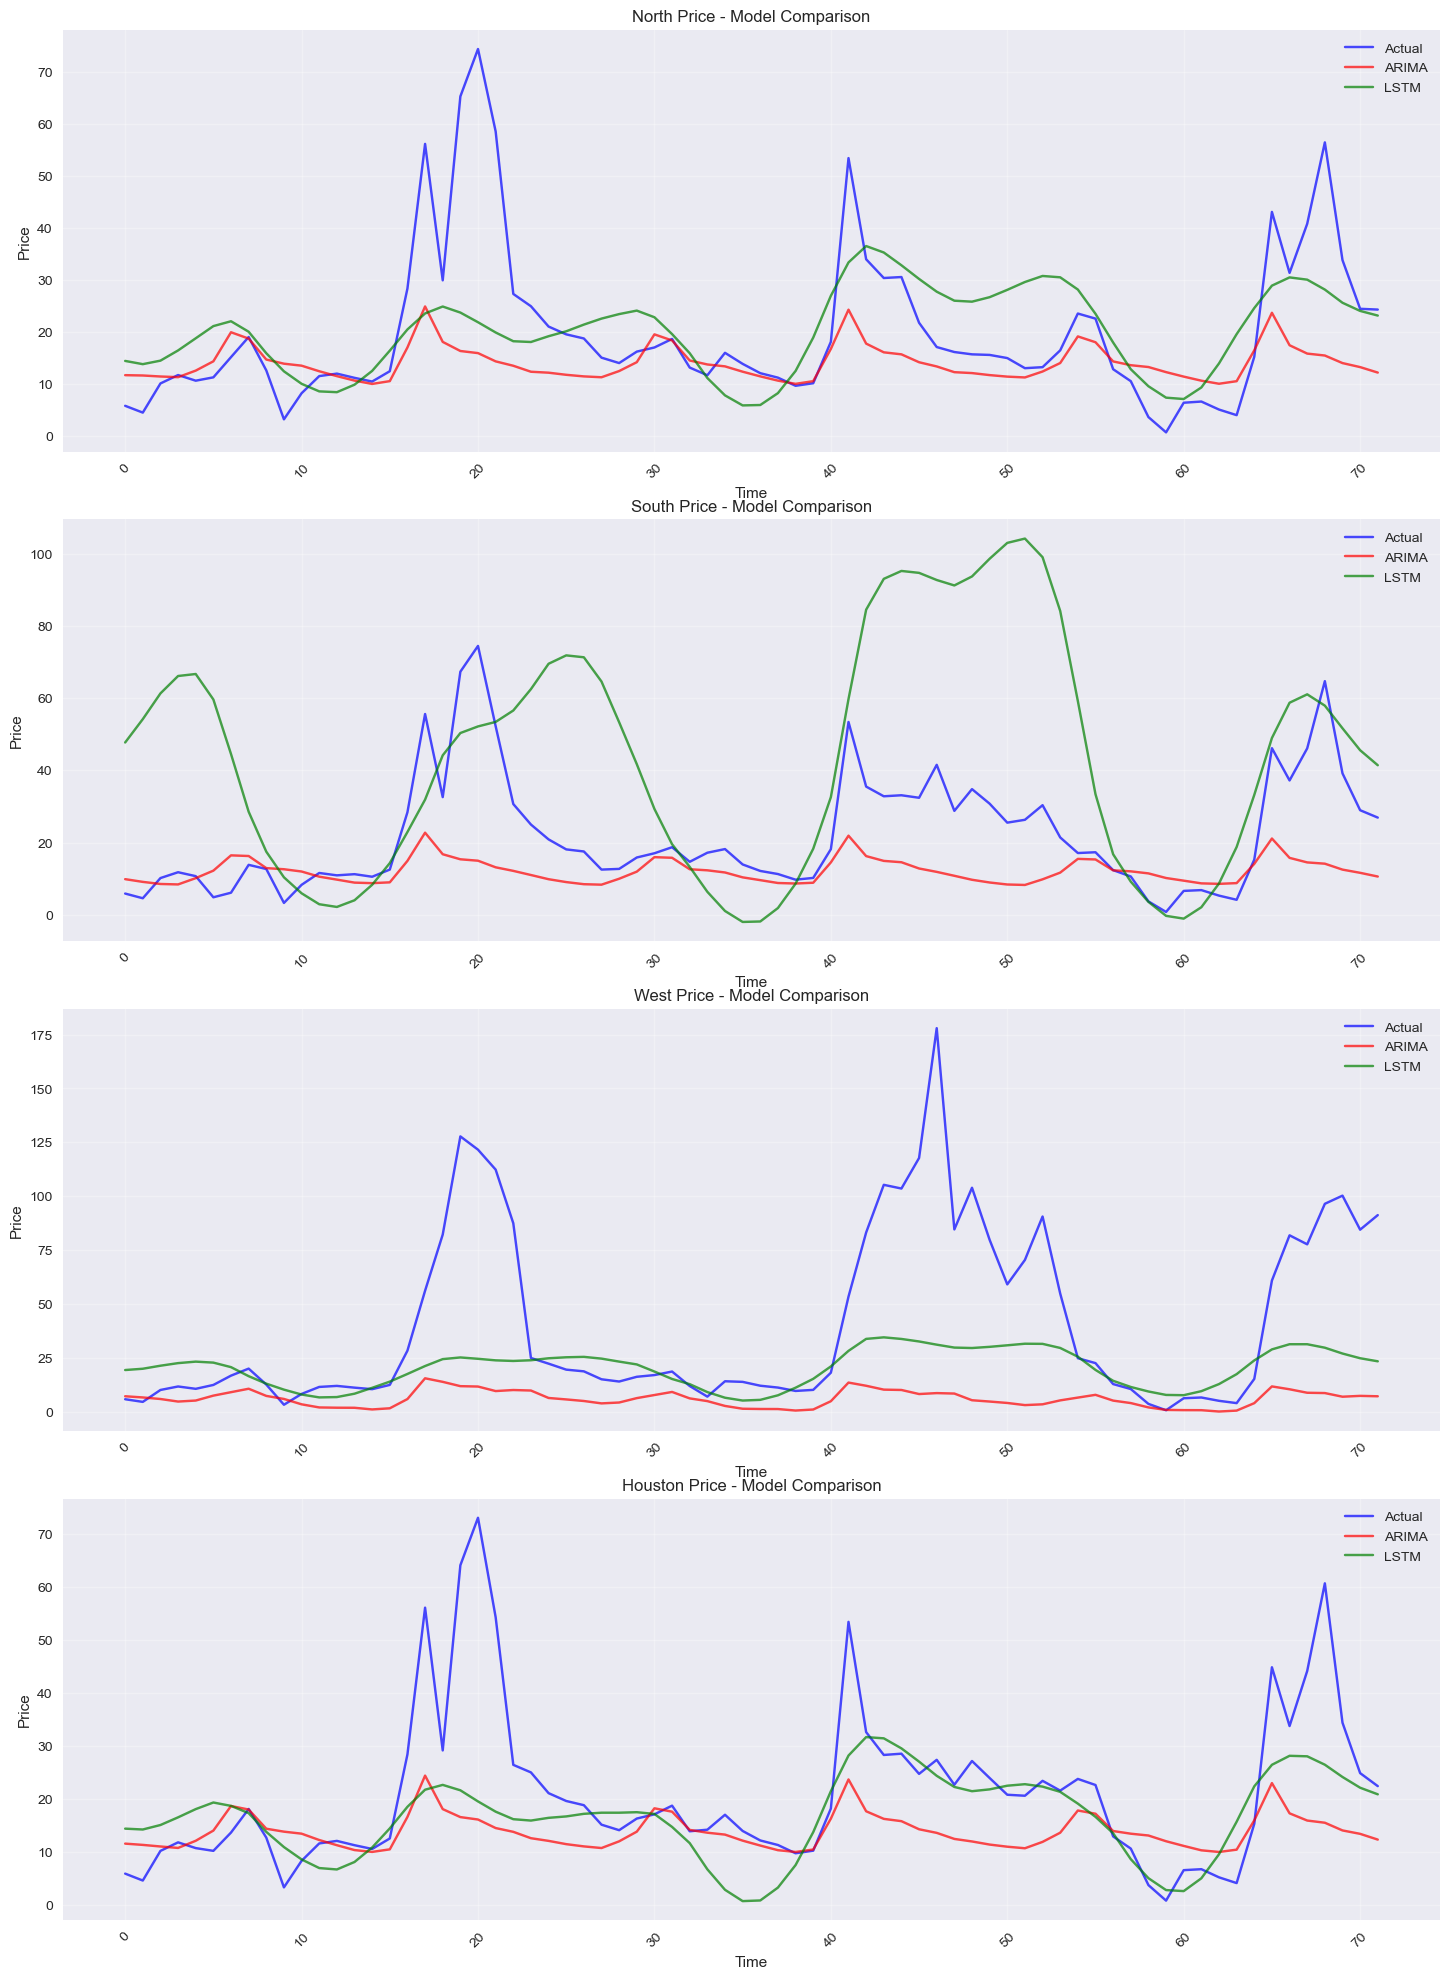

c:\Users\achra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\achra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\achra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\achra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

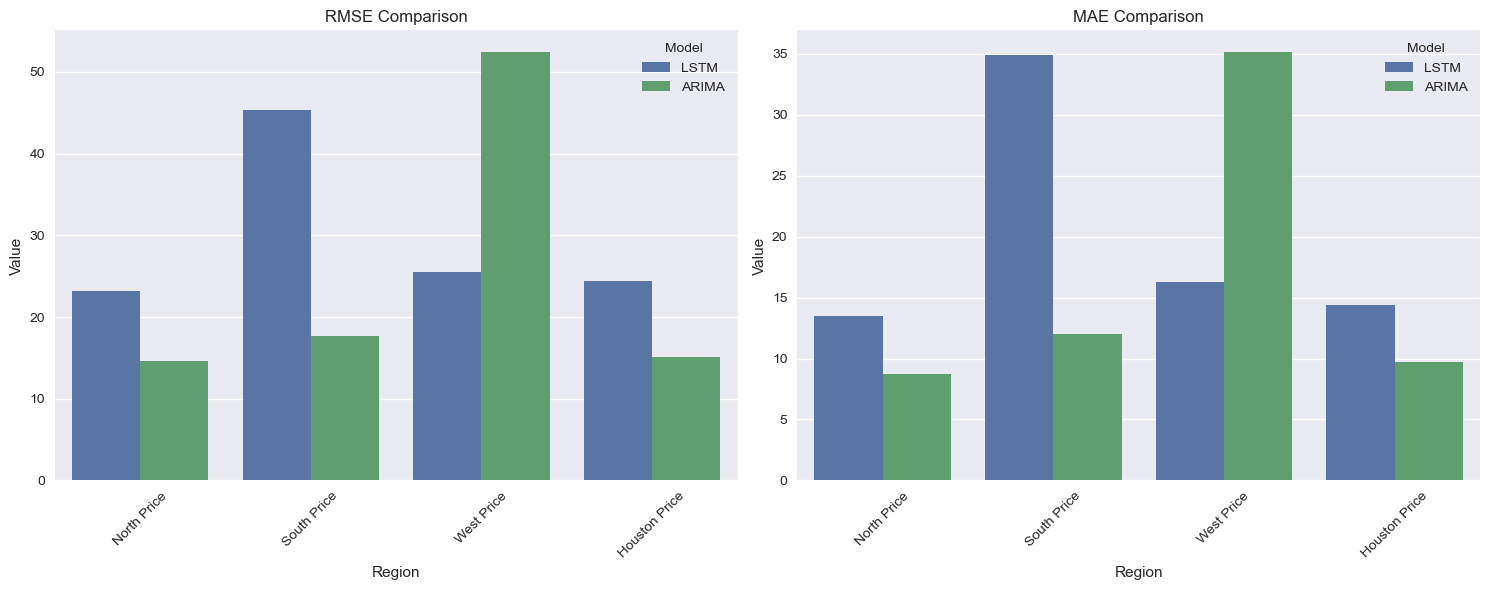


Detailed Comparison:

North Price:
LSTM - RMSE: 23.18, MAE: 13.52
ARIMA - RMSE: 14.65, MAE: 8.73
LSTM improvement over ARIMA:
RMSE improvement: -58.30%
MAE improvement: -54.89%

South Price:
LSTM - RMSE: 45.37, MAE: 34.88
ARIMA - RMSE: 17.72, MAE: 12.04
LSTM improvement over ARIMA:
RMSE improvement: -156.11%
MAE improvement: -189.82%

West Price:
LSTM - RMSE: 25.51, MAE: 16.26
ARIMA - RMSE: 52.46, MAE: 35.15
LSTM improvement over ARIMA:
RMSE improvement: 51.37%
MAE improvement: 53.73%

Houston Price:
LSTM - RMSE: 24.38, MAE: 14.39
ARIMA - RMSE: 15.11, MAE: 9.70
LSTM improvement over ARIMA:
RMSE improvement: -61.27%
MAE improvement: -48.33%


In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compare_models(lstm_predictions, lstm_actuals, arima_predictions, arima_actuals, target_columns):
    # Find the shorter length
    n_steps = min(len(lstm_predictions), len(arima_predictions))
    
    # Truncate both predictions to the same length
    lstm_predictions = lstm_predictions[-n_steps:]
    lstm_actuals = lstm_actuals[-n_steps:]
    arima_predictions = arima_predictions.iloc[-n_steps:]
    arima_actuals = arima_actuals.iloc[-n_steps:]
    
    # Calculate metrics for both models
    metrics_comparison = {}
    
    for column in target_columns:
        # LSTM metrics
        lstm_rmse = np.sqrt(mean_squared_error(lstm_actuals[:, target_columns.index(column)], 
                                             lstm_predictions[:, target_columns.index(column)]))
        lstm_mae = mean_absolute_error(lstm_actuals[:, target_columns.index(column)], 
                                     lstm_predictions[:, target_columns.index(column)])
        
        # ARIMA metrics
        arima_rmse = np.sqrt(mean_squared_error(arima_actuals[column], arima_predictions[column]))
        arima_mae = mean_absolute_error(arima_actuals[column], arima_predictions[column])
        
        metrics_comparison[column] = {
            'LSTM_RMSE': lstm_rmse,
            'LSTM_MAE': lstm_mae,
            'ARIMA_RMSE': arima_rmse,
            'ARIMA_MAE': arima_mae
        }
    
    # Create comparison plots
    fig, axes = plt.subplots(len(target_columns), 1, figsize=(15, 5*len(target_columns)))
    fig.tight_layout(pad=3.0)
    
    if len(target_columns) == 1:
        axes = [axes]
    
    for idx, column in enumerate(target_columns):
        ax = axes[idx]
        
        # Create time index for plotting
        time_index = arima_actuals.index
        
        # Plot actual values
        ax.plot(time_index, arima_actuals[column], 
                label='Actual', color='blue', alpha=0.7)
        
        # Plot ARIMA predictions
        ax.plot(time_index, arima_predictions[column], 
                label='ARIMA', color='red', alpha=0.7)
        
        # Plot LSTM predictions
        ax.plot(time_index, lstm_predictions[:, idx], 
                label='LSTM', color='green', alpha=0.7)
        
        ax.set_title(f'{column} - Model Comparison')
        ax.set_xlabel('Time')
        ax.set_ylabel('Price')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.setp(ax.get_xticklabels(), rotation=45)
    
    plt.show()
    
    # Create metrics comparison plot
    metrics_data = {
        'Region': [],
        'Model': [],
        'Metric': [],
        'Value': []
    }
    
    for region in target_columns:
        for model in ['LSTM', 'ARIMA']:
            for metric in ['RMSE', 'MAE']:
                metrics_data['Region'].append(region)
                metrics_data['Model'].append(model)
                metrics_data['Metric'].append(metric)
                metrics_data['Value'].append(
                    metrics_comparison[region][f'{model}_{metric}']
                )
    
    metrics_df = pd.DataFrame(metrics_data)
    
    # Plot metrics comparison
    plt.figure(figsize=(15, 6))
    for i, metric in enumerate(['RMSE', 'MAE'], 1):
        plt.subplot(1, 2, i)
        sns.barplot(data=metrics_df[metrics_df['Metric'] == metric],
                   x='Region', y='Value', hue='Model')
        plt.title(f'{metric} Comparison')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nDetailed Comparison:")
    for region in target_columns:
        print(f"\n{region}:")
        print(f"LSTM - RMSE: {metrics_comparison[region]['LSTM_RMSE']:.2f}, "
              f"MAE: {metrics_comparison[region]['LSTM_MAE']:.2f}")
        print(f"ARIMA - RMSE: {metrics_comparison[region]['ARIMA_RMSE']:.2f}, "
              f"MAE: {metrics_comparison[region]['ARIMA_MAE']:.2f}")
        
        # Calculate percentage improvements
        rmse_improvement = ((metrics_comparison[region]['ARIMA_RMSE'] - 
                           metrics_comparison[region]['LSTM_RMSE']) / 
                          metrics_comparison[region]['ARIMA_RMSE'] * 100)
        
        mae_improvement = ((metrics_comparison[region]['ARIMA_MAE'] - 
                          metrics_comparison[region]['LSTM_MAE']) / 
                         metrics_comparison[region]['ARIMA_MAE'] * 100)
        
        print(f"LSTM improvement over ARIMA:")
        print(f"RMSE improvement: {rmse_improvement:.2f}%")
        print(f"MAE improvement: {mae_improvement:.2f}%")

# Print shapes before comparison
print("Shapes before alignment:")
print(f"LSTM predictions shape: {test_pred_inv.shape}")
print(f"ARIMA predictions shape: {predictions.shape}")
print(f"ARIMA actuals shape: {actuals.shape}")

# Call the comparison function
compare_models(test_pred_inv, test_actual_inv, 
              predictions, actuals, 
              target_columns)

In [138]:
print("Training data shapes:", X_train.shape, y_train.shape)
print("Testing data shapes:", X_test.shape, y_test.shape)
print("NaN in training:", np.any(np.isnan(X_train)), np.any(np.isnan(y_train)))
print("Inf in training:", np.any(np.isinf(X_train)), np.any(np.isinf(y_train)))
print("NaN in testing:", np.any(np.isnan(X_test)), np.any(np.isnan(y_test)))
print("Inf in testing:", np.any(np.isinf(X_test)), np.any(np.isinf(y_test)))

Training data shapes: (901, 24, 46) (901, 4)
Testing data shapes: (144, 24, 46) (144, 4)
NaN in training: False False
Inf in training: False False
NaN in testing: False False
Inf in testing: False False
